# Predicting Retail Warehouse Locations
## Introduction
Logistics has become a hot area for investment across the supply chain, from startups disrupting the trucking space all the way down to the commercial real estate on which warehouses are built. Major retailers like Amazon and Walmart are ever expanding their warehouse footprint in competition with each other to get goods and services to customers as fast as possible and at the best price – this requires scale. Moreover, US warehouse square footage is expected to reach 15 billion by 2023.

The average age of a U.S. warehouse is 34 years, according to a survey by real estate services firm CBRE. And that likely won't cut it for a retail industry that's moving increasingly toward e-commerce and fulfilling online orders for customers same day. In surveying facilities across 56 markets throughout the country, CBRE found most warehouses built before about 2005 lack modern upgrades: Ceilings are low, flooring is uneven and space is tight.

New construction of facilities that retailers are increasingly hungry for has been hitting the West and South, including California's Inland Empire, Las Vegas, Phoenix and Atlanta. Industrial land plots of 5 to 10 acres, which typically house distribution centers for completing "last-mile" deliveries, watched their prices soar to more than 250,000 USD per acre by the end of 2017, up from roughly 200,000 USD the year before.

With this as the backdrop, our goal is to build a classification model to predict high probability zones for future warehouse locations.

## Methodology
### County-Level Approach
Our analysis included 2364 out of roughly 3000 counties in the United States. This provided a good combination of practicality and interpretability. Analysis was narrowed to Amazon and Walmart locations.
### Data Sources
Data primarily sourced from:
U.S. Census Bureau ACS Survey
Zillow Home Value Index
USDA Economic Research Service Surveys
Publicly-available warehouse location data
### Analysis of Key Demographic Information
Demographic characteristics were examined for prediction
Including: population density, median household income, unemployment rate, education level, net migration rate.
### Modeling 
We used Logistic Regression to build models to estimate the relative probability of the eestablishment of future warehouse locations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from imblearn.over_sampling import SMOTE as SMOTE_imb
from imblearn.pipeline import Pipeline as imb
from sklearn.metrics import roc_curve


/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
%run warehouse_functions.py

<Figure size 432x288 with 0 Axes>

In [19]:
df = pd.read_csv('retail_warehouses.csv', index_col=0)
df.head()

,county,state,state_abbrev,size_rank,avg_home_price,area_sq_mi,unemployment_rate,unemployment_change,less_high_school,high_school,...,int_migration_rate,net_migration_rate,pop_growth,poverty_rate,median_hh_income,property_tax_rate,amazon_indicator,walmart_indicator,warehouse_target,pop_density
0,Los Angeles County,California,CA,1,560333.416667,4750.94,4.8,-7.7,21.8,20.7,...,3.456049,-5.558295,3.016829,14.9,64912,0.699057,0,1,1,2129.843568
1,San Diego County,California,CA,5,530174.833333,4525.68,4.0,-6.8,13.3,18.6,...,3.435935,-1.311985,7.158882,11.9,76048,0.699057,0,0,0,734.799632
2,Orange County,California,CA,6,670382.666667,948.07,3.5,-6.2,15.3,17.3,...,3.266434,-2.430615,5.416470,11.5,86031,0.699057,0,0,0,3354.129969
3,Riverside County,California,CA,11,341060.000000,7303.42,5.2,-8.6,18.9,26.4,...,0.807951,8.932883,9.791375,12.9,63776,0.699057,1,1,1,330.971517
4,San Bernardino County,California,CA,12,307173.166667,20104.83,4.9,-8.6,20.8,26.2,...,0.721653,1.506749,5.502104,16.0,60270,0.699057,1,1,1,107.098792


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2363 entries, 0 to 2362
Data columns (total 23 columns):
county                   2363 non-null object
state                    2363 non-null object
state_abbrev             2363 non-null object
size_rank                2363 non-null int64
avg_home_price           2363 non-null float64
area_sq_mi               2363 non-null float64
unemployment_rate        2363 non-null float64
unemployment_change      2363 non-null float64
less_high_school         2363 non-null float64
high_school              2363 non-null float64
college_or_associates    2363 non-null float64
bachelors                2363 non-null float64
population               2363 non-null int64
int_migration_rate       2363 non-null float64
net_migration_rate       2363 non-null float64
pop_growth               2363 non-null float64
poverty_rate             2363 non-null float64
median_hh_income         2363 non-null int64
property_tax_rate        2363 non-null float64
amazon_in

### Hypothesis Test Features
#### Null Hypothesis: There is no difference in mean between counties with Amazon and/or Walmart warehouses and those without
#### Alternative Hypothesis: There is a difference in mean...
The intuition here is that there is some internal framework that large logistics companies rely on when selection locations for their warehouses and that this preference translates to significant differences in countywide population parameters.  

In [14]:
#defining the set of features we want to run hypothesis tests on
hypothesis_cols = df.drop(['county','state','state_abbrev','amazon_indicator','walmart_indicator','warehouse_target'], axis=1)

In [6]:
# divide the dataset in two: one set with counties where a warehouse is present, the other warehouse is absent
present = df.loc[df['warehouse_target']==1, :]
absent = df.loc[df['warehouse_target']==0, :]

In [9]:
#list of 1000 replicates for each feature
'''The idea here is that we have imbalanced populations, but we can simulate the drawing
of 1000 mean sample statistics (replicates) for each feature set for counties where 
target=1 (Amazon and/or Walmart warehouse present) and where target=0 (Amazon and/or Walmart warehouse absent)'''
means = []
for feature in hypothesis_cols:
    wh_present = present[feature].values
    wh_absent = absent[feature].values
    
    means_present = draw_bs_reps(wh_present, np.mean, 1000)
    means_absent = draw_bs_reps(wh_absent, np.mean, 1000)
    mean_set = (means_present, means_absent)
    means.append(mean_set)

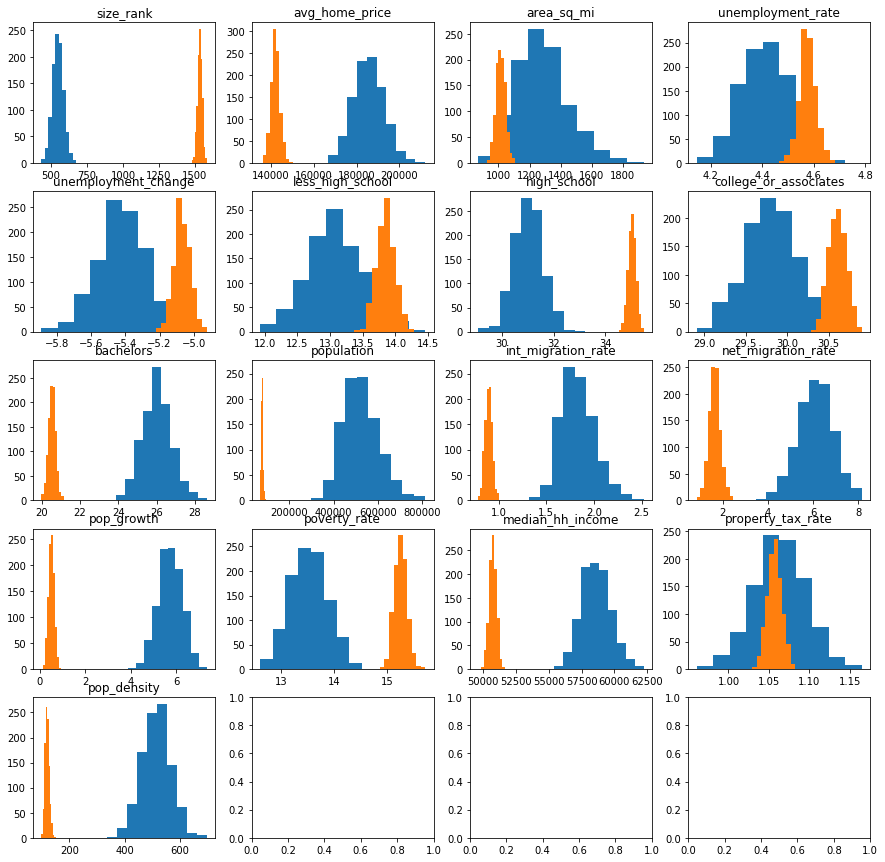

In [25]:
'''A visual Analysis of the distributions shows that some means are different, after building the first model
with all independent variables, we build a second model to test the notion that selecting only features with 
different means will improve accuracy'''
try: 
    hist_plot_1()
except IndexError:
    pass

### Logistic Regression Model

In [2]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/retail_warehouses.csv')
df = df.select_dtypes(include=['int','float'])
df.drop(['Unnamed: 0','latitude','longitude'],axis=1,inplace=True)

X= df.drop('warehouse_target',axis=1)
y = df.warehouse_target

X = df[['size_rank', 'avg_home_price', 'high_school', 'bachelors', 'population', 'int_migration_rate', 'net_migration_rate',
        'pop_growth', 'poverty_rate', 'median_hh_income', 'pop_density']]

In [6]:
# split into 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y) 
  
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (1654, 11)
Number transactions y_train dataset:  (1654,)
Number transactions X_test dataset:  (709, 11)
Number transactions y_test dataset:  (709,)


In [14]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       658
           1       0.62      0.10      0.17        51

    accuracy                           0.93       709
   macro avg       0.78      0.55      0.57       709
weighted avg       0.91      0.93      0.91       709



In [9]:
conf_matrix = pd.DataFrame(confusion_matrix(y_train, lr.predict(X_train)),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,1528,8
actual 1,105,13


The model classified almost all observations as '0' .

### Logistic Regression with SMOTE

In [10]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

Before OverSampling, counts of label '1': 118
Before OverSampling, counts of label '0': 1536 

After OverSampling, the shape of train_X: (3072, 11)
After OverSampling, the shape of train_y: (3072,) 

After OverSampling, counts of label '1': 1536
After OverSampling, counts of label '0': 1536


/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [11]:
lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 

# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       658
           1       0.19      0.76      0.30        51

    accuracy                           0.74       709
   macro avg       0.58      0.75      0.57       709
weighted avg       0.92      0.74      0.80       709



/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [12]:
conf_matrix = pd.DataFrame(confusion_matrix(y_train, lr1.predict(X_train)),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,1151,385
actual 1,29,89


**SMOTE massively improved our true positive (Recall) rate, and overall accuracy.**

</br>

We will focus on the false positive values, as they are a proxy for potential warehouse locations.

### LR Model with SMOTE and Selected Features

### Comparing Predicted False Positives with Actual True Positives

In [140]:
df['Log_pred'] = lr1.predict(X)
df['Log_probabilities'] = lr1.predict_proba(X)[:,1]

In [161]:
# Top 50 predicted false positives
fp = df.sort_values('Log_probabilities',ascending=False).loc[(df.warehouse_target == 0) & (df.Log_pred == 1)].head(50)
fp.head()

,county,state,state_abbrev,size_rank,avg_home_price,area_sq_mi,unemployment_rate,unemployment_change,less_high_school,high_school,...,poverty_rate,median_hh_income,property_tax_rate,amazon_indicator,walmart_indicator,warehouse_target,pop_density,Log_pred,Log_ pro,Log_probabilities
1,San Diego County,California,CA,5,530174.833333,4525.68,4.0,-6.8,13.3,18.6,...,11.9,76048,0.699057,0,0,0,734.799632,1,0.990700,0.990700
486,Oakland County,Michigan,MI,32,223026.000000,907.29,3.5,-8.3,6.3,19.2,...,7.8,77558,1.368569,0,0,0,1384.542980,1,0.967730,0.967730
367,Broward County,Florida,FL,18,238740.333333,1322.86,4.0,-6.2,11.4,27.2,...,13.1,56702,0.885964,0,0,0,1462.339930,1,0.964002,0.964002
154,Collin County,Texas,TX,74,318400.833333,886.10,3.5,-3.7,6.4,15.1,...,5.9,95394,1.615935,0,0,0,1096.256630,1,0.962542,0.962542
157,Fort Bend County,Texas,TX,107,256508.416667,885.34,4.6,-3.0,10.3,17.2,...,8.0,91661,1.615935,0,0,0,865.357942,1,0.962509,0.962509


In [158]:
#list of 1000 replicates for each feature
post_means = []
for feature in hypothesis_cols:
    wh_present = present[feature].values
    fp_absent = fp[feature].values
    
    means_present = draw_bs_reps(wh_present, np.mean, 1000)
    means_absent = draw_bs_reps(fp_absent, np.mean, 1000)
    mean_set = (means_present, means_absent)
    post_means.append(mean_set)

IndexError: list index out of range

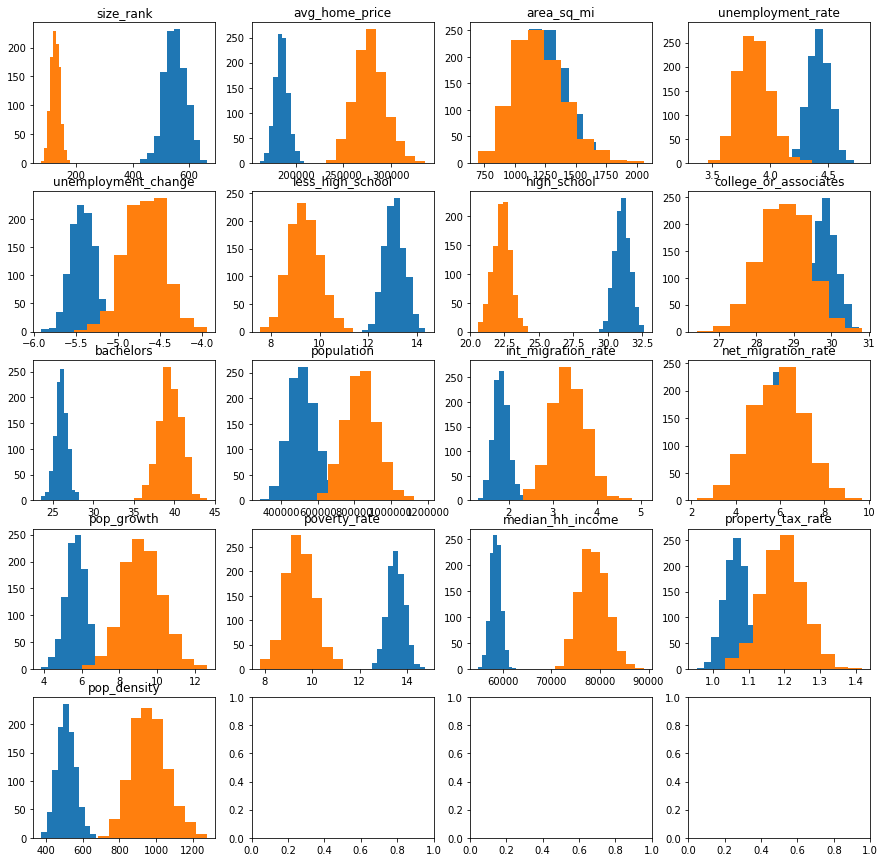

In [159]:
columns = list(hypothesis_cols.columns)
fig, axs = plt.subplots(5, 4,figsize=(15,15))

axs[0, 0].hist(post_means[0][0])
axs[0, 0].hist(post_means[0][1])
axs[0, 0].set_title(f'{columns[0]}')
axs[0, 1].hist(post_means[1][0])
axs[0, 1].hist(post_means[1][1])
axs[0, 1].set_title(f'{columns[1]}')
axs[0, 2].hist(post_means[2][0])
axs[0, 2].hist(post_means[2][1])
axs[0, 2].set_title(f'{columns[2]}')
axs[0, 3].hist(post_means[3][0])
axs[0, 3].hist(post_means[3][1])
axs[0, 3].set_title(f'{columns[3]}')
axs[1, 0].hist(post_means[4][0])
axs[1, 0].hist(post_means[4][1])
axs[1, 0].set_title(f'{columns[4]}')
axs[1, 1].hist(post_means[5][0])
axs[1, 1].hist(post_means[5][1])
axs[1, 1].set_title(f'{columns[5]}')
axs[1, 2].hist(post_means[6][0])
axs[1, 2].hist(post_means[6][1])
axs[1, 2].set_title(f'{columns[6]}')
axs[1, 3].hist(post_means[7][0])
axs[1, 3].hist(post_means[7][1])
axs[1, 3].set_title(f'{columns[7]}')
axs[2, 0].hist(post_means[8][0])
axs[2, 0].hist(post_means[8][1])
axs[2, 0].set_title(f'{columns[8]}')
axs[2, 1].hist(post_means[9][0])
axs[2, 1].hist(post_means[9][1])
axs[2, 1].set_title(f'{columns[9]}')
axs[2, 2].hist(post_means[10][0])
axs[2, 2].hist(post_means[10][1])
axs[2, 2].set_title(f'{columns[10]}')
axs[2, 3].hist(post_means[11][0])
axs[2, 3].hist(post_means[11][1])
axs[2, 3].set_title(f'{columns[11]}')
axs[3, 0].hist(post_means[12][0])
axs[3, 0].hist(post_means[12][1])
axs[3, 0].set_title(f'{columns[12]}')
axs[3, 1].hist(post_means[13][0])
axs[3, 1].hist(post_means[13][1])
axs[3, 1].set_title(f'{columns[13]}')
axs[3, 2].hist(post_means[14][0])
axs[3, 2].hist(post_means[14][1])
axs[3, 2].set_title(f'{columns[14]}')
axs[3, 3].hist(post_means[15][0])
axs[3, 3].hist(post_means[15][1])
axs[3, 3].set_title(f'{columns[15]}')
axs[4, 0].hist(post_means[16][0])
axs[4, 0].hist(post_means[16][1])
axs[4, 0].set_title(f'{columns[16]}')
axs[4, 1].hist(post_means[17][0])
axs[4, 1].hist(post_means[17][1])
axs[4, 1].set_title(f'{columns[17]}')
axs[4, 2].hist(post_means[18][0])
axs[4, 2].hist(post_means[18][1])
axs[4, 2].set_title(f'{columns[18]}')
axs[4, 3].hist(post_means[19][0])
axs[4, 3].hist(post_means[19][1])
axs[4, 3].set_title(f'{columns[19]}')
for ax in axs.flat:
    ax.set(xlabel='', ylabel='frequency')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [136]:
conf_matrix = pd.DataFrame(confusion_matrix(y_train, lr1.predict(X_train)),
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,1153,383
actual 1,27,91


In [131]:
X= hypothesis_cols
y = df.warehouse_target

#Set up hyperparameter grid
c_range = [1]
param_grid = {'lr__C': c_range, 'lr__penalty': ['l1','l2']}

# Set up pipeline
steps = [('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000))]

pipeline = Pipeline(steps)

# Instantiate GridSearchCV
pipeline_cv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=25)

# Fit the pipeline to the training data
pipeline_cv.fit(X_train, y_train)

# Print optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(pipeline_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(pipeline_cv.best_score_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Tuned Logistic Regression Parameter: {'lr__C': 1, 'lr__penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.9333333333333333


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


In [124]:
hypothesis_cols

,size_rank,avg_home_price,area_sq_mi,unemployment_rate,unemployment_change,less_high_school,high_school,college_or_associates,bachelors,population,int_migration_rate,net_migration_rate,pop_growth,poverty_rate,median_hh_income,property_tax_rate,pop_density
0,1,560333.416667,4750.94,4.8,-7.7,21.8,20.7,26.2,31.2,10118759,3.456049,-5.558295,3.016829,14.9,64912,0.699057,2129.843568
1,5,530174.833333,4525.68,4.0,-6.8,13.3,18.6,30.7,37.4,3325468,3.435935,-1.311985,7.158882,11.9,76048,0.699057,734.799632
2,6,670382.666667,948.07,3.5,-6.2,15.3,17.3,28.3,39.1,3179950,3.266434,-2.430615,5.416470,11.5,86031,0.699057,3354.129969
3,11,341060.000000,7303.42,5.2,-8.6,18.9,26.4,33.2,21.5,2417224,0.807951,8.932883,9.791375,12.9,63776,0.699057,330.971517
4,12,307173.166667,20104.83,4.9,-8.6,20.8,26.2,33.2,19.8,2153203,0.721653,1.506749,5.502104,16.0,60270,0.699057,107.098792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,2521,237732.166667,4174.60,4.2,-2.6,4.6,33.4,35.2,26.8,8442,0.000000,-2.127408,-1.722934,9.5,55412,0.575889,2.022230
2359,2525,164219.083333,2242.70,4.0,-1.9,11.5,29.0,38.6,21.0,8035,-0.617170,-16.046411,-5.803048,10.7,57989,0.575889,3.582735
2360,2613,166224.750000,2400.02,4.0,-0.8,8.1,34.4,37.7,19.8,6986,4.225650,-34.227763,-2.958744,10.6,56214,0.575889,2.910809
2361,2621,242739.583333,2865.30,3.5,-1.5,7.4,30.6,41.2,20.7,7424,2.947679,-17.284116,4.255020,7.7,61664,0.575889,2.591003


In [132]:
y_train_predict = pipeline_cv.predict(X_train)
y_train_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [133]:
pd.DataFrame(confusion_matrix(y_train, y_train_predict), 
             columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,1749,6
actual 1,117,18


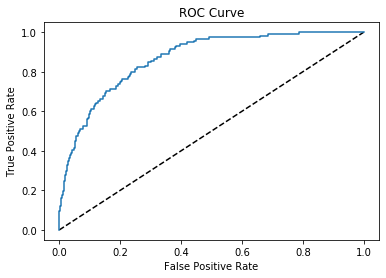

In [72]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipeline_cv.predict_proba(X_train)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [116]:
thresholds

array([1.99975191e+00, 9.99751910e-01, 7.72225707e-01, 7.66999833e-01,
       6.49949497e-01, 6.47795966e-01, 5.55360483e-01, 5.17661504e-01,
       5.12864272e-01, 4.99478119e-01, 4.98056236e-01, 4.97812229e-01,
       4.94912893e-01, 4.57410607e-01, 4.45729504e-01, 4.26275538e-01,
       4.19796192e-01, 4.00153802e-01, 3.95728673e-01, 3.75353344e-01,
       3.75068787e-01, 3.74483425e-01, 3.73412891e-01, 3.67215220e-01,
       3.58603231e-01, 3.56932075e-01, 3.41448534e-01, 3.33286822e-01,
       3.32712504e-01, 3.29347193e-01, 3.28708077e-01, 3.24328854e-01,
       3.19359985e-01, 3.10426944e-01, 3.08788668e-01, 3.06765614e-01,
       3.03128766e-01, 3.00293750e-01, 2.93053205e-01, 2.89980146e-01,
       2.86720793e-01, 2.83982052e-01, 2.81956661e-01, 2.77823176e-01,
       2.77635915e-01, 2.77002675e-01, 2.76343550e-01, 2.72995688e-01,
       2.72295813e-01, 2.67235642e-01, 2.66137687e-01, 2.63929674e-01,
       2.62027947e-01, 2.53852156e-01, 2.52494253e-01, 2.43670632e-01,
      